In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
import cv2
%matplotlib inline

import matplotlib.pyplot as plt
#from IPython import display

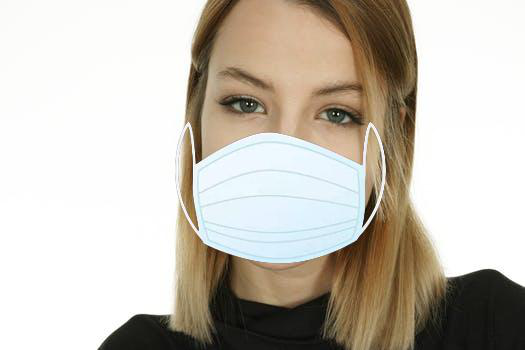

In [13]:
# TEST YOUR VERSION OF PILLOW
# Run this cell. If you see a picture of a cat you're all set!
with Image.open('../Data/MASKS-UNMASKS/with_mask/1-with-mask.jpg') as im:
    display(im)

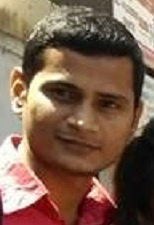

In [14]:
with Image.open('../Data/MASKS-UNMASKS/without_mask/1.jpg') as im:
    display(im)

(154, 225)


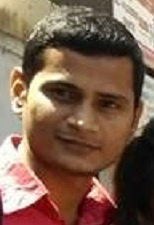

In [16]:
unmask= Image.open('../Data/MASKS-UNMASKS/without_mask/1.jpg')
print(unmask.size)
display(unmask)

### Create a list of image filenames

In [18]:
path = '../Data/MASKS-UNMASKS'
print(path)
img_names = []
#print([filenames for filenames in os.walk(path)])
for folders,subfolders,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folders+'\\'+img)
        
print('Images: ',len(img_names))

../Data/MASKS-UNMASKS
Images:  2884


In [19]:
# Start by creating a list
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  2884
Rejects: 0


In [20]:
# Convert the list to a DataFrame
df = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df[0].describe()

count    2884.000000
mean      361.977462
std       269.443659
min       110.000000
25%       259.000000
50%       320.000000
75%       327.000000
max      3456.000000
Name: 0, dtype: float64

In [39]:
# Run summary statistics on image heights
df[1].describe()

count    2884.000000
mean      425.734743
std       319.597590
min       141.000000
25%       275.000000
50%       428.000000
75%       433.000000
max      5184.000000
Name: 1, dtype: float64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 448, 448])


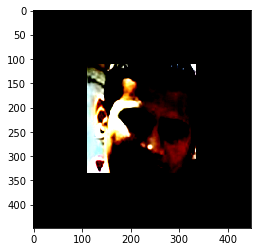

In [40]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.CenterCrop(448),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
im = transform(unmask)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [41]:
im[:,0,0] # pytorch automatically loads the pixel channels to [0,1]

tensor([-2.1179, -2.0357, -1.8044])

In [42]:
# After normalization:
im[:,0,0]

tensor([-2.1179, -2.0357, -1.8044])

When displayed, matplotlib clipped this particular pixel up to [0,0,0] so it appears black on the screen. However, the appearance isn't important; the goal of normalization is improved mathematical performance.

### Optional: De-normalize the images
To see the image back in its true colors, we can apply an inverse-transform to the tensor being displayed.

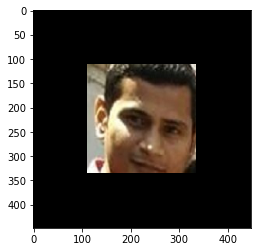

In [43]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


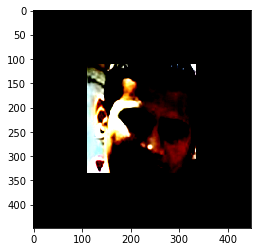

In [44]:
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [45]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [46]:
root = '../Data/MASKS-UNMASKS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(111)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['with_mask', 'without_mask']
Training images available: 1314
Testing images available:  194


Label: [1 0 0 0 1 1 0 1 1 0]
Class: without_mask with_mask with_mask with_mask without_mask without_mask with_mask without_mask without_mask with_mask


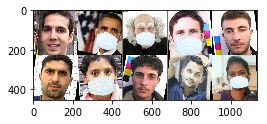

In [47]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(4,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [48]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [56]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [57]:
def train_model(model, criterion, optimizer, num_epochs=3):
    max_trn_batch = 140
    max_tst_batch = 20

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(num_epochs):
        trn_corr = 0
        tst_corr = 0

        # Run the training batches
        for b, (X_train, y_train) in enumerate(train_loader):

            # Limit the number of batches
            if b == max_trn_batch:
                break
            b+=1

            # Apply the model
            y_pred = CNNmodel(X_train)
            loss = criterion(y_pred, y_train)

            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print interim results
            if b%35 == 0:
                print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/1314]  loss: {loss.item():10.8f}  \
    accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # Run the testing batches
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):
                # Limit the number of batches
                if b == max_tst_batch:
                    break

                # Apply the model
                y_val = CNNmodel(X_test)

                # Tally the number of correct predictions
                predicted = torch.max(y_val.data, 1)[1] 
                tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
        print(test_correct)
        print(f'Test accuracy: {test_correct[-1].item()*100/194:.3f}%')
       

In [58]:
model=train_model(CNNmodel, criterion, optimizer, num_epochs=3)

epoch:  0  batch:   35 [   350/1314]  loss: 0.12082118      accuracy:  80.571%
epoch:  0  batch:   70 [   700/1314]  loss: 0.01588967      accuracy:  85.857%
epoch:  0  batch:  105 [  1050/1314]  loss: 0.06196322      accuracy:  88.667%
[tensor(186)]
Test accuracy: 95.876%
epoch:  1  batch:   35 [   350/1314]  loss: 0.01724733      accuracy:  96.571%
epoch:  1  batch:   70 [   700/1314]  loss: 0.37878555      accuracy:  96.429%
epoch:  1  batch:  105 [  1050/1314]  loss: 0.07107218      accuracy:  96.571%
[tensor(186), tensor(188)]
Test accuracy: 96.907%
epoch:  2  batch:   35 [   350/1314]  loss: 0.00302134      accuracy:  98.286%
epoch:  2  batch:   70 [   700/1314]  loss: 0.00752801      accuracy:  97.571%
epoch:  2  batch:  105 [  1050/1314]  loss: 0.05132655      accuracy:  97.333%
[tensor(186), tensor(188), tensor(188)]
Test accuracy: 96.907%


In [59]:
torch.save(CNNmodel.state_dict(), 'MASKSCNNModel.pt')

In [60]:
AlexNetmodel = models.alexnet(pretrained=True)
for param in AlexNetmodel.parameters():
    param.requires_grad = False
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [62]:
torch.manual_seed(101)

In [63]:
train_model(AlexNetmodel, criterion, optimizer, num_epochs=3)

epoch:  0  batch:   35 [   350/1314]  loss: 0.00419678      accuracy:  98.571%
epoch:  0  batch:   70 [   700/1314]  loss: 0.00673922      accuracy:  98.143%
epoch:  0  batch:  105 [  1050/1314]  loss: 0.02493756      accuracy:  98.476%
[tensor(188)]
Test accuracy: 96.907%
epoch:  1  batch:   35 [   350/1314]  loss: 0.01048794      accuracy:  98.571%
epoch:  1  batch:   70 [   700/1314]  loss: 0.31933779      accuracy:  98.143%
epoch:  1  batch:  105 [  1050/1314]  loss: 0.16738740      accuracy:  97.905%
[tensor(188), tensor(188)]
Test accuracy: 96.907%
epoch:  2  batch:   35 [   350/1314]  loss: 0.01717900      accuracy:  97.714%
epoch:  2  batch:   70 [   700/1314]  loss: 0.04063513      accuracy:  98.143%
epoch:  2  batch:  105 [  1050/1314]  loss: 0.05238069      accuracy:  98.190%
[tensor(188), tensor(188), tensor(188)]
Test accuracy: 96.907%


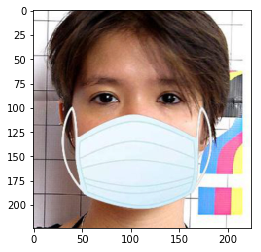

In [64]:
x = 6
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [65]:
#Prediction using CNNmodel
CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 with_mask


In [66]:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 with_mask
